In [4]:
!pip install facenet-pytorch


: 

In [ ]:
from facenet_pytorch import InceptionResnetV1
import torch
import torch.nn as nn
import torch.nn.functional as F


ModuleNotFoundError: No module named 'facenet_pytorch'

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EmbeddingPoisoner(nn.Module):
    def __init__(self, facenet, epsilon=0.01, targeted=False, target_embedding=None):
        super().__init__()
        self.facenet = facenet.eval()
        self.epsilon = epsilon
        self.targeted = targeted
        self.target_embedding = target_embedding

    def forward(self, x):
        x = x.clone().detach().requires_grad_(True)

        emb = self.facenet(x)

        if self.targeted and self.target_embedding is not None:
            loss = -F.cosine_similarity(emb, self.target_embedding).mean()
        else:
            loss = torch.norm(emb, p=2)

        grad = torch.autograd.grad(loss, x, retain_graph=False, create_graph=False)[0]

        x_adv = x + self.epsilon * grad.sign()
        x_adv = torch.clamp(x_adv, 0, 1)

        return x_adv.detach()


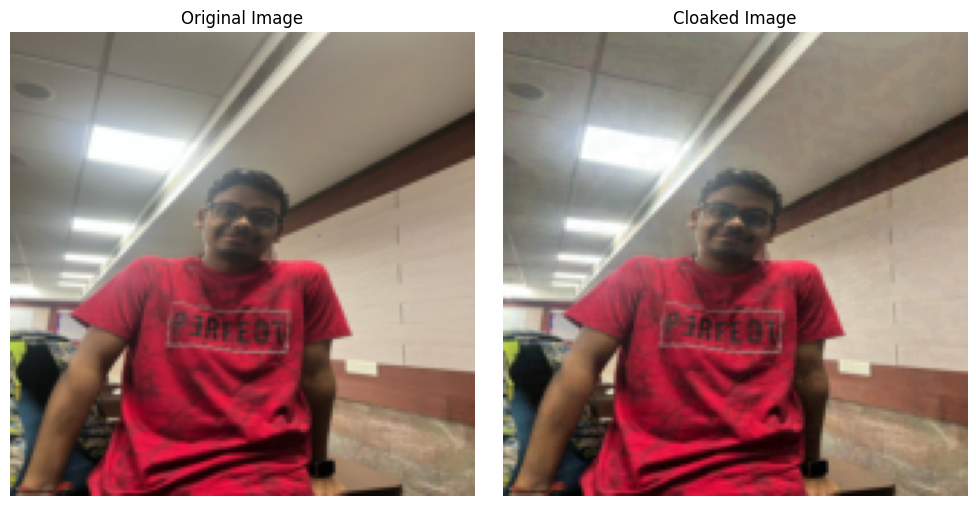


Original Embedding:
[[-0.00279061 -0.0078667  -0.02117192  0.07173377 -0.00653812  0.02796005
  -0.0073513  -0.02727894 -0.06383324 -0.04728372  0.00112877 -0.02705893
  -0.05976943 -0.04634245 -0.00313569 -0.05904378  0.07388016  0.10076204
   0.05576527 -0.05212144 -0.03970683  0.02431515  0.03854411 -0.05694731
  -0.05790182  0.01796384  0.05701088 -0.0112861  -0.00351757  0.01579163
  -0.05115405  0.05845995  0.00706574 -0.0208558  -0.02205916 -0.03451445
  -0.02202304 -0.02817312 -0.02861278  0.01792892 -0.0504442  -0.02673488
  -0.00307673 -0.04657622  0.01735855 -0.05204607  0.03294035  0.07823979
  -0.02741138  0.0140175  -0.0148736   0.10021085  0.06952345  0.00861268
  -0.00776041 -0.02299042  0.02484447  0.13199623  0.04258994  0.03168837
  -0.04222202  0.00428074  0.04542361 -0.04747239  0.00092635  0.04066203
  -0.01117068  0.02356362 -0.05912542 -0.04281563  0.00616087  0.03719838
   0.03577062 -0.00161667 -0.02136406 -0.0477885   0.01438828 -0.07929961
  -0.04370529 -0.

In [17]:
import torch
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load FaceNet
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load and preprocess image
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

image_path = "Vats.jpg"
if not os.path.exists(image_path):
    raise FileNotFoundError(f"Couldn't find {image_path}. Please add a test image.")

img = Image.open(image_path).convert("RGB")
x = transform(img).unsqueeze(0).to(device)

# Poisoner model
poisoner = EmbeddingPoisoner(facenet, epsilon=0.01).to(device)

# Original embedding
with torch.no_grad():
    original_emb = facenet(x)

# Get cloaked image
x_cloaked = poisoner(x)

# Embedding for cloaked image
with torch.no_grad():
    cloaked_emb = facenet(x_cloaked)

# Cosine similarity
cos = torch.nn.CosineSimilarity(dim=1)
similarity = cos(original_emb, cloaked_emb).item()

# Delta
delta_emb = cloaked_emb - original_emb
delta_norm = torch.norm(delta_emb).item()

# Save images
vutils.save_image(x, "original.png", normalize=True)
vutils.save_image(x_cloaked, "cloaked.png", normalize=True)

# Display images
original_img = transforms.ToPILImage()(x.squeeze().cpu())
cloaked_img = transforms.ToPILImage()(x_cloaked.squeeze().cpu())

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_img)
axs[0].set_title("Original Image")
axs[0].axis('off')

axs[1].imshow(cloaked_img)
axs[1].set_title("Cloaked Image")
axs[1].axis('off')

plt.tight_layout()
plt.show()

# Print embedding info
print("\n=========================")
print("Original Embedding:")
print(original_emb.cpu().numpy())

print("\nCloaked Embedding:")
print(cloaked_emb.cpu().numpy())

print("\nCosine Similarity:", round(similarity, 4))
print("Embedding Δ Norm: ", round(delta_norm, 4))
print("=========================\n")


In [18]:
import torch
from facenet_pytorch import InceptionResnetV1
from torchvision import transforms
from PIL import Image
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load facenet
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Load original image to get original embedding
img_path = "original.png"
img_cloaked_path = "cloaked.png"

if not os.path.exists(img_path) or not os.path.exists(img_cloaked_path):
    raise FileNotFoundError("Make sure both test_face.jpg and cloaked.png exist in the folder!")

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor()
])

# Load both images
img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)

img_cloaked = Image.open(img_cloaked_path).convert("RGB")
img_cloaked_tensor = transform(img_cloaked).unsqueeze(0).to(device)

# Get embeddings
with torch.no_grad():
    original_emb = facenet(img_tensor)
    cloaked_emb = facenet(img_cloaked_tensor)

# Cosine similarity
cos = torch.nn.CosineSimilarity(dim=1)
similarity = cos(original_emb, cloaked_emb).item()
delta = torch.norm(cloaked_emb - original_emb).item()

print("\n===============================")
print("📌 Original vs Cloaked FaceNet Output")
print("-------------------------------")
print("Cosine Similarity:", round(similarity, 4))
print("L2 Delta (||orig - cloaked||):", round(delta, 4))

# Optional match thresholding
threshold = 0.8
if similarity > threshold:
    print("✅ FaceNet still thinks it's the same person")
else:
    print("🛡️ Cloaking successful — model is confused!")
print("===============================\n")



📌 Original vs Cloaked FaceNet Output
-------------------------------
Cosine Similarity: 0.8908
L2 Delta (||orig - cloaked||): 0.4673
✅ FaceNet still thinks it's the same person



c:\Anaconda\envs\finalenv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\bhatt\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


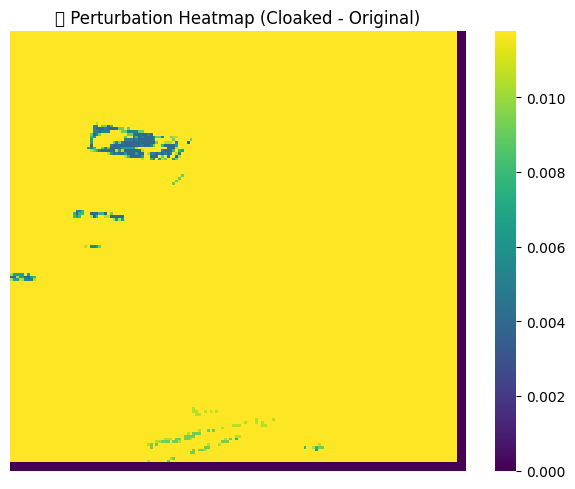

c:\Anaconda\envs\finalenv\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\bhatt\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


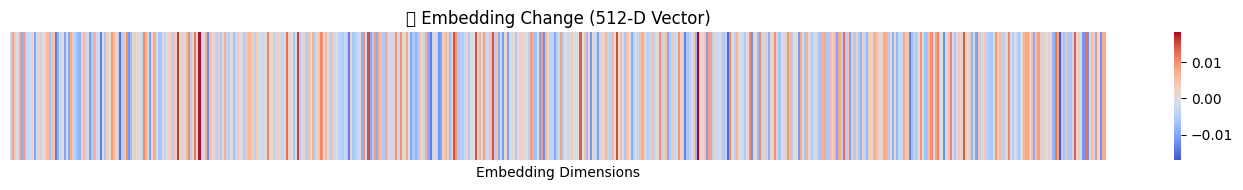

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === 1. PIXEL-WISE HEATMAP: What changed visually?

# Get diff image (normalized for display)
diff_img = torch.abs(img_tensor.squeeze() - img_cloaked_tensor.squeeze()).cpu()
diff_img = diff_img.mean(dim=0)  # average across channels for gray heatmap

plt.figure(figsize=(6, 5))
plt.title("📸 Perturbation Heatmap (Cloaked - Original)")
sns.heatmap(diff_img, cmap='viridis', cbar=True)
plt.axis('off')
plt.tight_layout()
plt.show()

# === 2. EMBEDDING HEATMAP: What changed in the FaceNet vector?

emb_diff = (cloaked_emb - original_emb).squeeze().cpu().numpy()

plt.figure(figsize=(14, 2))
plt.title("🔬 Embedding Change (512-D Vector)")
sns.heatmap(emb_diff[np.newaxis, :], cmap="coolwarm", center=0, cbar=True, xticklabels=False, yticklabels=False)
plt.xlabel("Embedding Dimensions")
plt.tight_layout()
plt.show()


C:\Users\bhatt\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


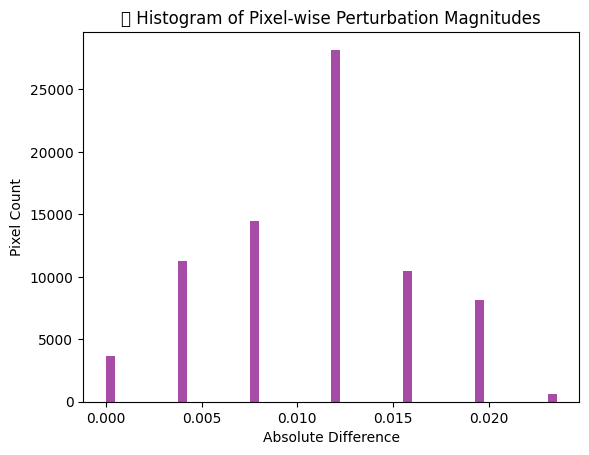

In [6]:
delta = (img_tensor - img_cloaked_tensor).abs().cpu().flatten().numpy()
plt.hist(delta, bins=50, color='purple', alpha=0.7)
plt.title("📊 Histogram of Pixel-wise Perturbation Magnitudes")
plt.xlabel("Absolute Difference")
plt.ylabel("Pixel Count")
plt.show()
